In [118]:
from os import makedirs
from os.path import join, splitext, basename
DIR_ROOT = "../data/test_dataset"
DIR_RENDITIONS = join(DIR_ROOT, "output/renditions")
DIR_CSVS = join(DIR_ROOT, "output/csvs")
DIR_VISUALIZATIONS = join(DIR_ROOT, "output/visualizations/region_props")
DIR_2ND_ORDER = join(DIR_CSVS, "second_order_entropy")

makedirs(DIR_RENDITIONS, exist_ok=True)
makedirs(DIR_CSVS, exist_ok=True)
makedirs(DIR_VISUALIZATIONS, exist_ok=True)
makedirs(DIR_2ND_ORDER, exist_ok=True)

# Define the rotation resolution and permute the possibilities

In [97]:
import numpy as np
from itertools import product

#define and generate the test angles
possible_angles = [0, 30, 60, 90, 45]
possible_angles = possible_angles + [angle + other_angle for angle, other_angle in zip(possible_angles, possible_angles)]
possible_angles = possible_angles + [-angle for angle in possible_angles]
#remove duplicates
possible_angles = set(possible_angles)
#expand the combinations
euler_angle_sets = product(possible_angles, repeat=3)
euler_angle_sets = list(euler_angle_sets)
euler_array = np.array(euler_angle_sets)
len(euler_angle_sets) * 4

8788

# Populate the Euler Angles dataframe

In [115]:
import polars as pl
from scipy.spatial.transform import Rotation
from glob import glob

EULER_ORDER = "YZX"

DIR_OBJECTS = "../data/PrefViews Null 3D objects"
CSV_ROTATION = join(DIR_CSVS, "rotation_data.csv")

toy_paths = glob(join(DIR_OBJECTS, "*.obj"))
toys = [splitext(basename(file))[0] for file in toy_paths]

# Create DataFrames and cross join
df_toys = pl.DataFrame({"Object": toys})
df_angles = pl.DataFrame({
    "Euler_X": euler_array[:, 2],
    "Euler_Y": euler_array[:, 0],
    "Euler_Z": euler_array[:, 1],
})

# Cross join = every toy with every angle
DF_ROTATIONS = df_toys.join(df_angles, how="cross")

#Add index

DF_ROTATIONS = DF_ROTATIONS.with_columns(
    pl.arange(0, pl.len()).alias("Index")
)
# Add primary key
DF_ROTATIONS = DF_ROTATIONS.with_columns(
    pl.concat_str([
        pl.col("Index"),
        pl.lit("_"),
        pl.col("Object")
    ]).alias("KID_IDFrameKey")
).select([
    "Index",
    "KID_IDFrameKey",
    pl.all().exclude(["Index", "KID_IDFrameKey"])
])

DF_ROTATIONS.write_csv(CSV_ROTATION)
DF_ROTATIONS

Index,KID_IDFrameKey,Object,Euler_X,Euler_Y,Euler_Z
i64,str,str,i64,i64,i64
0,"""0_CribNovel""","""CribNovel""",0,0,0
1,"""1_CribNovel""","""CribNovel""",-30,0,0
2,"""2_CribNovel""","""CribNovel""",-60,0,0
3,"""3_CribNovel""","""CribNovel""",-90,0,0
4,"""4_CribNovel""","""CribNovel""",-120,0,0
…,…,…,…,…,…
8783,"""8783_CameraNovel""","""CameraNovel""",180,30,30
8784,"""8784_CameraNovel""","""CameraNovel""",120,30,30
8785,"""8785_CameraNovel""","""CameraNovel""",90,30,30


# Generate the renditions for each rotation

In [99]:
from novel_toy_tools.utils.generate_renditions import generate_renditions_rot_mat

generate_renditions_rot_mat(CSV_ROTATION, DIR_RENDITIONS, DIR_OBJECTS)

Saving renditions to ../data/test_dataset/output/renditions


Generating Renditions: 100%|██████████| 8788/8788 [00:32<00:00, 273.14it/s]


# run the moments script from matlab
### navigate to the src directory in matlab, run the printed script, and hit enter once you return

In [ ]:
print(f"simple_region_props('{DIR_RENDITIONS}','{DIR_CSVS}','*.jpg')")

navigate to the src directory in matlab, run the printed script, and hit enter once you return 


simple_region_props('../data/test_dataset/output/renditions','../data/test_dataset/output/csvs','*.jpg')


In [ ]:
input("confirm that you have run the script")

# zip together the csvs

In [123]:
CSV_REGION = join(DIR_CSVS, "fit_ellipse_moments.csv")

DF_REGION = pl.read_csv(CSV_REGION)


DF_MASTER = DF_ROTATIONS.join(
    DF_REGION,
    on='KID_IDFrameKey',
    how='inner'
).sort("Index")

DF_MASTER.write_csv(join(DIR_CSVS, "combined_dataset.csv"))

# We're going to add another column that measures the angle from the vertical of the fit ellipse

In [ ]:
DF_MASTER = DF_MASTER.with_columns(
    pl.when(pl.col('orientation_degrees') < 0) # angle is measured below the horizontal
    .then(90.0 + pl.col('orientation_degrees')) # then the angle from the vertical is the compliment from 90
    .otherwise(90 - pl.col('orientation_degrees')) # then the angle is measured from the horizontal counter clockwise, check its distance from 90
    .alias('orientation_degrees_from_vertical')
)

# for debugging we're going to compute the axis features and display them

In [ ]:
OBJECT_AXES_MODIFIED = {
    "Airplane" : np.array([0,1,0]), #changed from [0,0,1]
    "AirplaneNovel" : np.array([0,1,0]),
    "Camera" : np.array([1,0,0]),
    "CameraNovel" : np.array([1,0,0]),
    "Crib" : np.array([1,0,0]),
    "CribNovel" : np.array([1,0,0]),
    "Cup" : np.array([0,0,1]), #changed from [0,1,0]
    "CupNovel" : np.array([0,0,1]), #changed from [0,1,0]
    "HighChair" : np.array([0,0,1]), #changed from [0,1,0]
    "HighChairNovel" : np.array([0,0,1]), #changed from [0,1,0]
    "Shoe" : np.array([1,0,0]), 
    "ShoeNovel" : np.array([1,0,0]),
    "Shovel" : np.array([1,0,0]),
    "ShovelNovel" : np.array([1,0,0]),
    "Train" : np.array([1,0,0]),
    "TrainNovel" : np.array([1,0,0]),
}

OBJECT_AXES_ORIGINAL = {
    "Airplane" : np.array([0,0,1]),
    "AirplaneNovel" : np.array([0,1,0]),
    "Camera" : np.array([1,0,0]),
    "CameraNovel" : np.array([1,0,0]),
    "Crib" : np.array([1,0,0]),
    "CribNovel" : np.array([1,0,0]),
    "Cup" : np.array([0,1,0]),
    "CupNovel" : np.array([0,1,0]),
    "HighChair" : np.array([0,1,0]),
    "HighChairNovel" : np.array([0,1,0]),
    "Shoe" : np.array([1,0,0]), 
    "ShoeNovel" : np.array([1,0,0]),
    "Shovel" : np.array([1,0,0]),
    "ShovelNovel" : np.array([1,0,0]),
    "Train" : np.array([1,0,0]),
    "TrainNovel" : np.array([1,0,0]),
}

In [ ]:
from major_axis_features import rotate_major_axis, compute_projected_angle_from_vertical

#rotate the major axis of the object based on the generated rotation
series_rotated_axes = []
series_axis_angle_from_vertical = []
for row in DF_MASTER.iter_rows(named=True):
    obj_major_axis = OBJECT_AXES_ORIGINAL[row['Object']]
    euler_x = row['Euler_X']
    euler_y = row['Euler_Y']
    euler_z = row['Euler_Z']
    obj_major_axis_rotated = rotate_major_axis(obj_major_axis, euler_x, euler_y, euler_z)
    series_rotated_axes.append(obj_major_axis_rotated)

    angle_from_vertical = compute_projected_angle_from_vertical(obj_major_axis_rotated)
    series_axis_angle_from_vertical.append(angle_from_vertical)

DF_MASTER = DF_MASTER.with_columns(
    pl.Series('rotated_major_axis', series_rotated_axes),
    pl.Series('projected_angle_from_vert', series_axis_angle_from_vertical)
)

# render a subset of the images for display

In [ ]:
from visualizations import render_props, visualize_fig1
DF_DEBUG = DF_MASTER.sample(n=200, shuffle=True)
DF_DEBUG = render_props(DF_DEBUG, DIR_RENDITIONS, DIR_VISUALIZATIONS)

# visualize the props

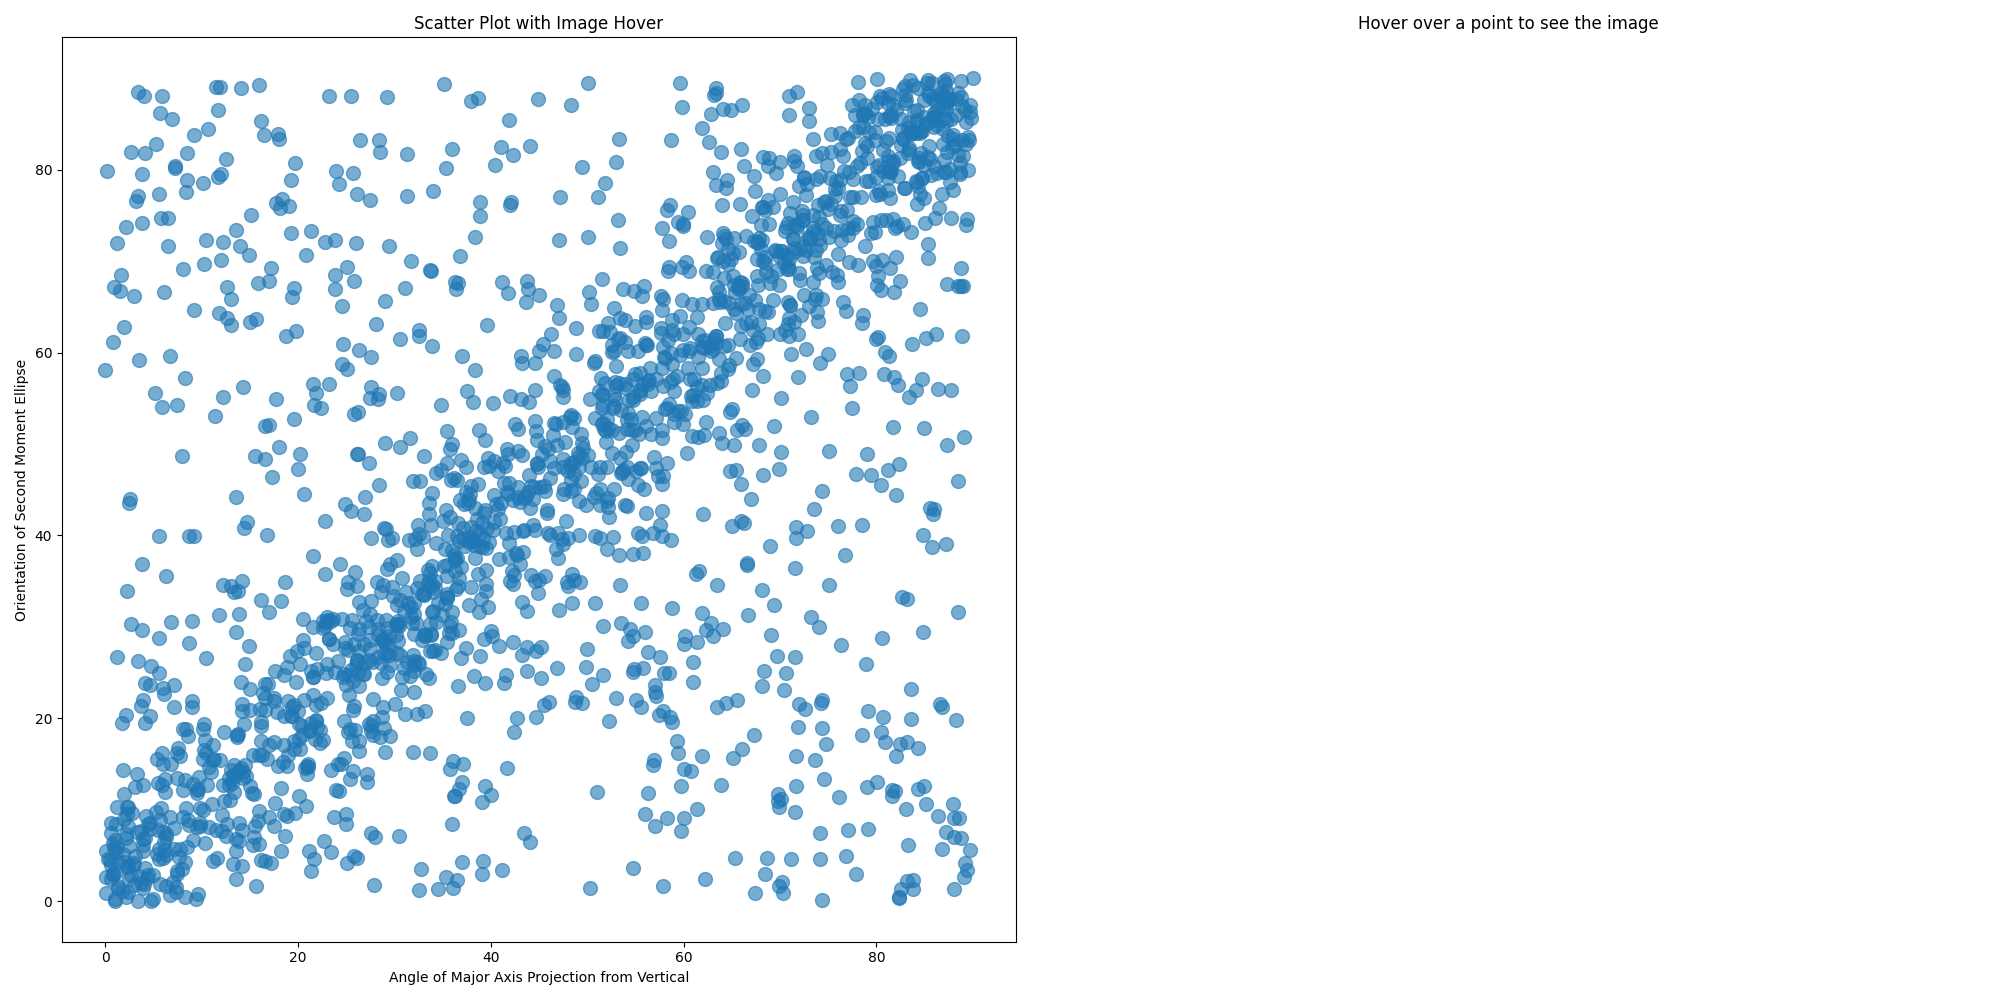

In [ ]:
# Enable interactive mode for Jupyter
%matplotlib widget

visualize_fig1(DF_DEBUG)

# Now run the edge entropy script from matlab
### navigate to the src directory in matlab, run the printed script, and hit enter once you return

In [122]:
print(f"edge_entropy('{DIR_RENDITIONS}','{DIR_CSVS}','{DIR_2ND_ORDER}')")

edge_entropy('../data/test_dataset/output/renditions','../data/test_dataset/output/csvs','../data/test_dataset/output/csvs/second_order_entropy')


In [ ]:
input("confirm that you have run the script")